In [181]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [182]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [183]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [184]:
train.describe(include = ['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [185]:
train.HomePlanet.value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [186]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [188]:
train.Age.max()

79.0

In [189]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

Посмотрим процентное соотношение между выжившими и не выжившими

<Axes: xlabel='Transported'>

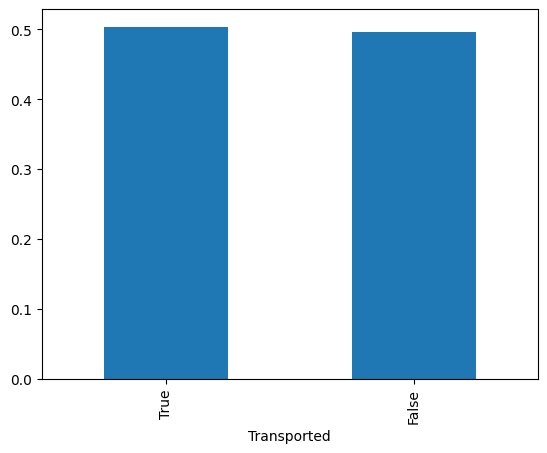

In [190]:
trainplt = train.Transported.value_counts(normalize=True)
trainplt.plot(kind="bar")

In [191]:
print(trainplt)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


Зависимость выживания от HomePlanet

<Axes: xlabel='HomePlanet', ylabel='Transported'>

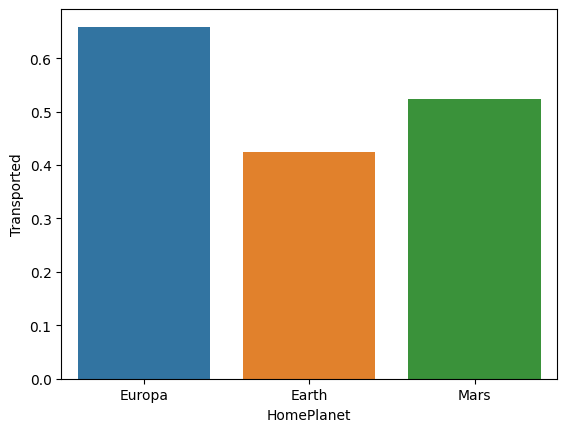

In [192]:
sns.barplot(x="HomePlanet", y="Transported", data=train, errorbar=None)

Transported ~ CryoSleep

<Axes: xlabel='CryoSleep'>

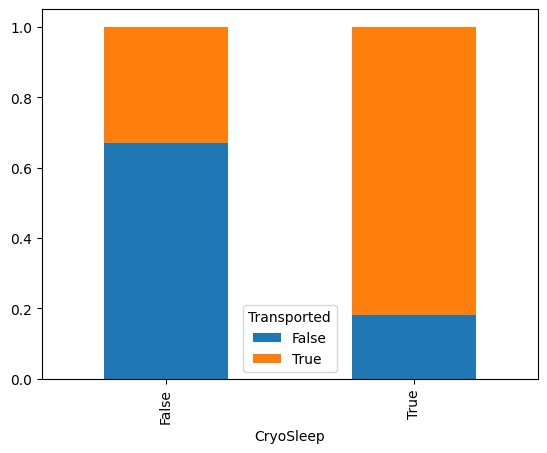

In [193]:
tab = pd.crosstab(train["CryoSleep"], train["Transported"])
tab.div(tab.sum(1), axis=0).plot(kind="bar", stacked=True)

Transported ~ Destination

<Axes: xlabel='Destination', ylabel='Transported'>

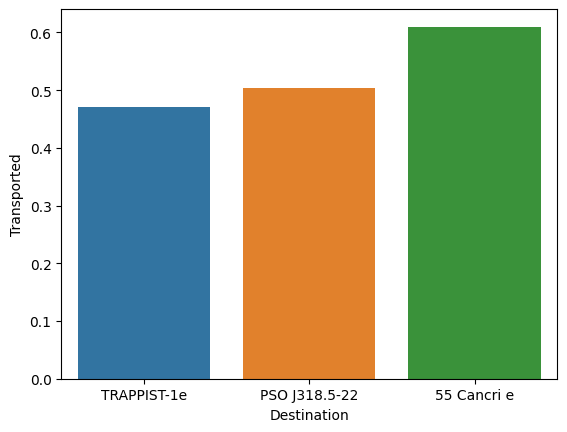

In [194]:
sns.barplot(x="Destination", y="Transported", data=train, errorbar=None)

Transported ~ VIP

<Axes: xlabel='VIP'>

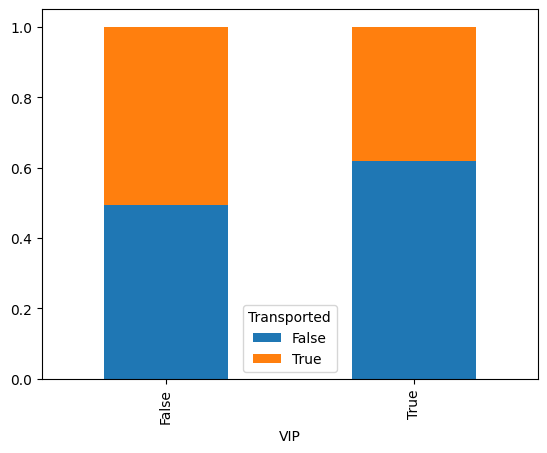

In [195]:
tab = pd.crosstab(train["VIP"], train["Transported"])
tab.div(tab.sum(1), axis=0).plot(kind="bar", stacked=True)

Разделим "Cabin" на "Deck", "CabNum" и "Board" 

In [196]:
trt = [train, test]
for t in trt:
    t[["Deck", "CabNum", "Board"]] = t.Cabin.str.split("/", expand=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabNum,Board
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


Посмотрим на распределение Board и Deck в тестовой и тренировочной выборках чтобы определить, чем заполнять nan

<Axes: xlabel='Deck'>

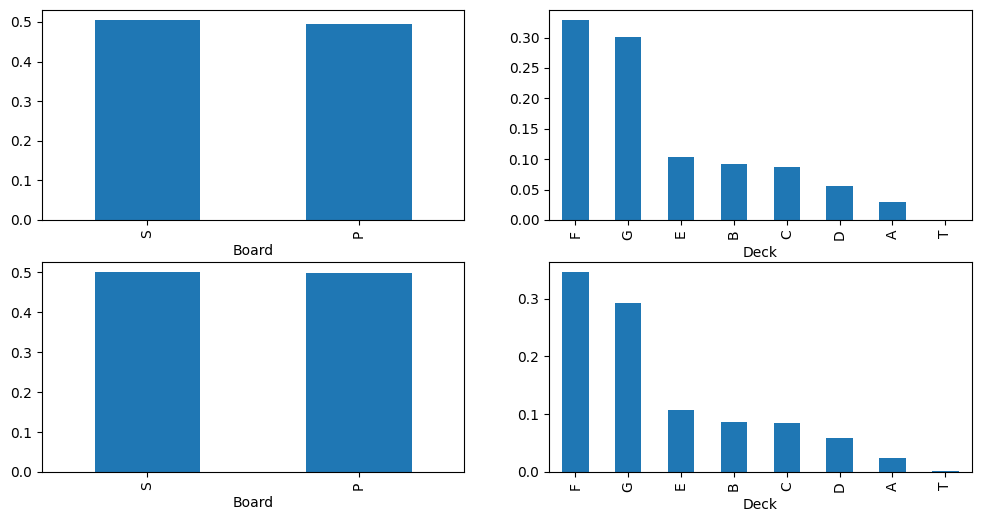

In [197]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
train.Board.value_counts(normalize=True).plot(kind="bar", ax=ax[0, 0])
train.Deck.value_counts(normalize=True).plot(kind="bar", ax=ax[0, 1])
test.Board.value_counts(normalize=True).plot(kind="bar", ax=ax[1, 0])
test.Deck.value_counts(normalize=True).plot(kind="bar", ax=ax[1, 1])

посмотрим на зависимость вероятности выживания от Board

<Axes: xlabel='Board', ylabel='Transported'>

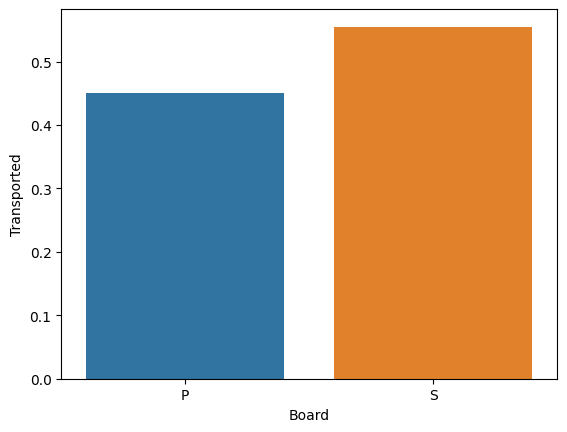

In [198]:
sns.barplot(x="Board", y="Transported", data=train, errorbar=None)

заменим P и S в Board на 0 и 1 (признак бинарный, OHE не требуется), заполним нули в Board рандомными значениями 0-1 т к распределение приблизительно равное и заполним нули в Deck модами (первой и второй)

In [199]:
board_mapping = {"P": 0, "S": 1}
deck_options = ["F", "G"]
for t in trt:
    t.Board = t.Board.map(board_mapping)
    t.loc[t.Board.isnull(), "Board"] = np.random.randint(0, 2, t.Board.isnull().sum())
    t.Board = t.Board.astype(int)
    t.loc[t.Deck.isnull(), "Deck"] = np.random.choice(deck_options, t.Deck.isnull().sum())
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabNum,Board
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,1


заполним CabNum рандомными значениями между максимумом и минимумом в пределах группы значений с теми же Deck и Board, а также добавим значение CNB (CabNumBound), ее значение очевидно из гистограммы ниже

In [200]:
for t in trt:
    t.CabNum = t.CabNum.astype("Int64")
    t.loc[t.CabNum.isnull(), 'CabNum'] = t[t.CabNum.isnull()].apply(
    lambda x: np.random.randint(
        t[(t['Deck'] == x['Deck']) & (t['Board'] == x['Board'])]['CabNum'].min(),
        t[(t['Deck'] == x['Deck']) & (t['Board'] == x['Board'])]['CabNum'].max() + 1
    ), axis=1
    )
    t.CabNum = t.CabNum.astype(int)
    t["CNB"] = np.floor(t.CabNum/37.86)
    t.CNB = t.CNB.astype(int)
print(train.CabNum.isnull().sum())

0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


37.86


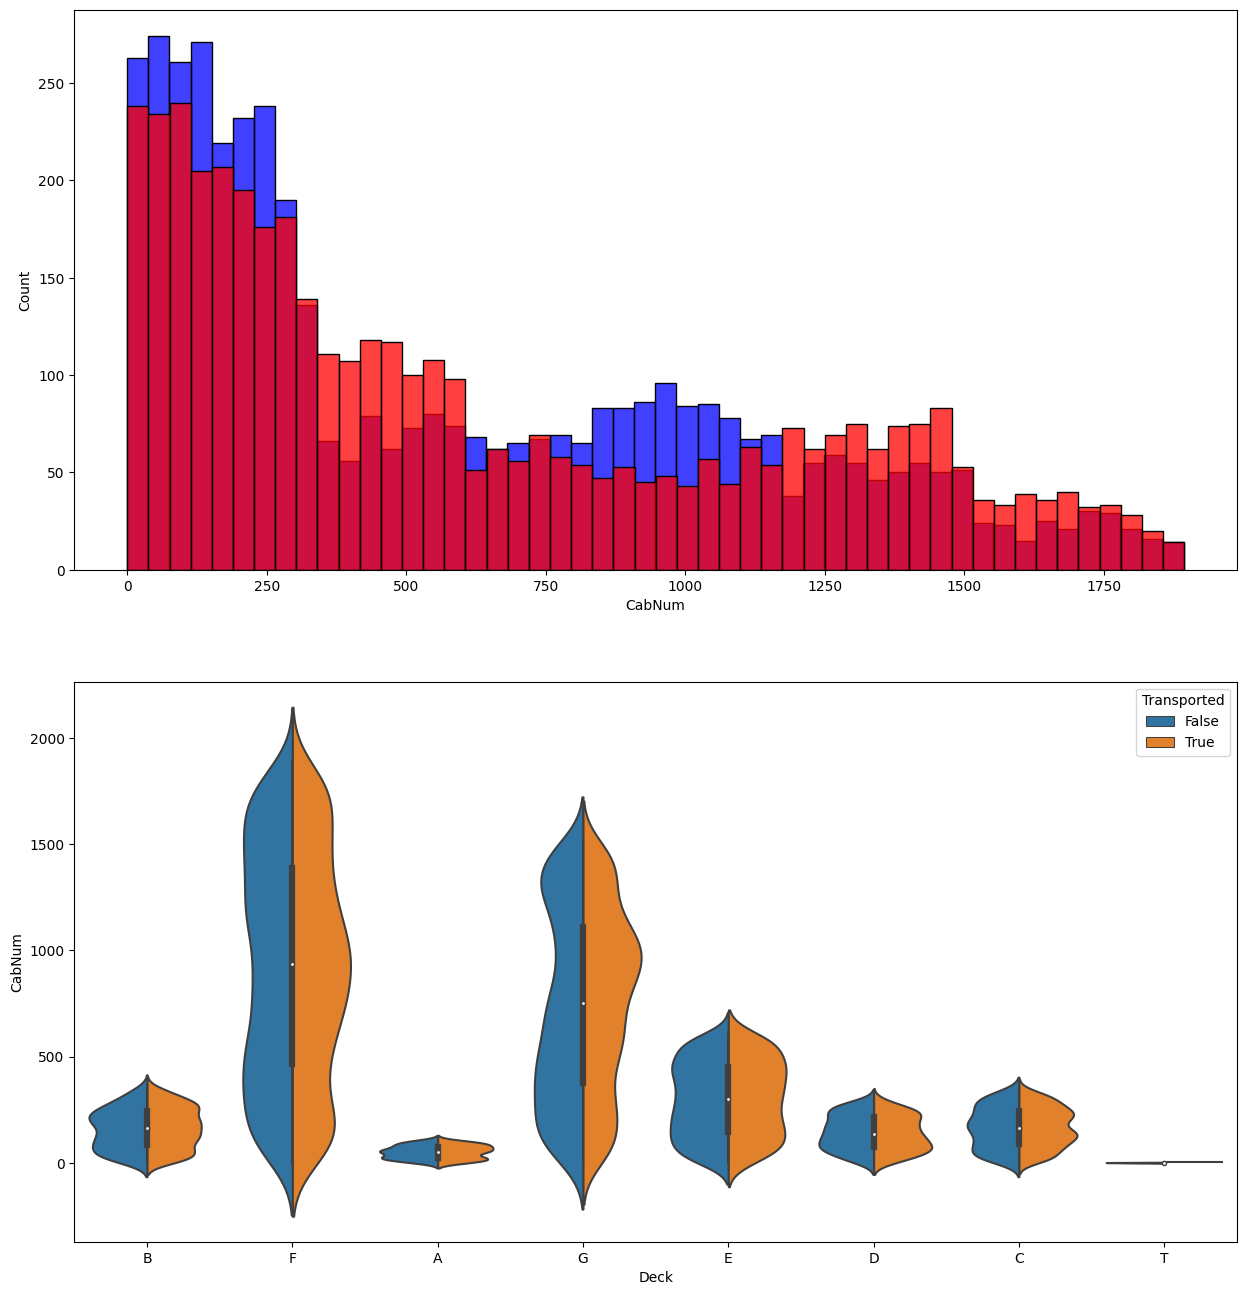

In [201]:
tr_survived = train[train.Transported]
tr_notsur = train[~train.Transported]
fig, ax = plt.subplots(2, 1, figsize=(15, 16))
sns.histplot(tr_survived.CabNum, color="blue", bins=50, ax=ax[0])
h = sns.histplot(tr_notsur.CabNum, color="red", bins=50, ax=ax[0])
sns.violinplot(x="Deck", y="CabNum", hue="Transported", data=train, split=True, ax=ax[1])
print(h.patches[0].get_width())

"Визуализируем" с помощью 3хмерного графика зону поражения, выводов сделать не удалось(

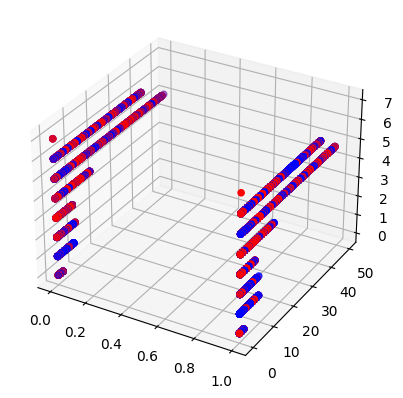

In [202]:
deck_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7}
color_mapping = {True: "blue", False: "red"}
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(train.Board, train.CNB, train.Deck.map(deck_mapping), c=train.Transported.map(color_mapping))

посмотрим на зависимость между палубой и вероятностью выживания

<Axes: xlabel='Deck', ylabel='Transported'>

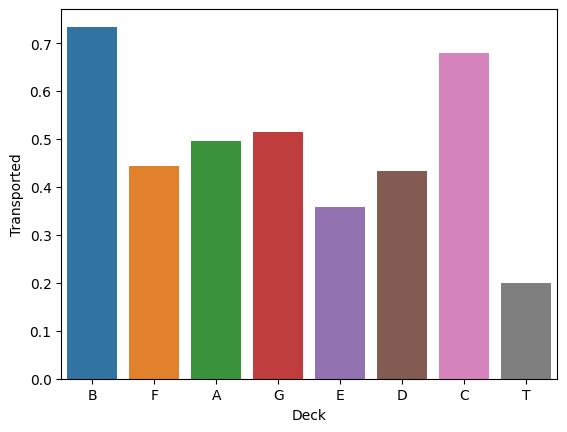

In [203]:
sns.barplot(x="Deck", y="Transported", data=train, errorbar=None)

применим OHE к deck

In [204]:
train = pd.get_dummies(train, columns=["Deck"], drop_first=True)
test = pd.get_dummies(test, columns=["Deck"], drop_first=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabNum,Board,CNB,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,0,0,True,False,False,False,False,False,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,1,0,False,False,False,False,True,False,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,1,0,False,False,False,False,False,False,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,1,0,False,False,False,False,False,False,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,1,0,False,False,False,False,True,False,False


распределение кают

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CabNum', ylabel='Count'>

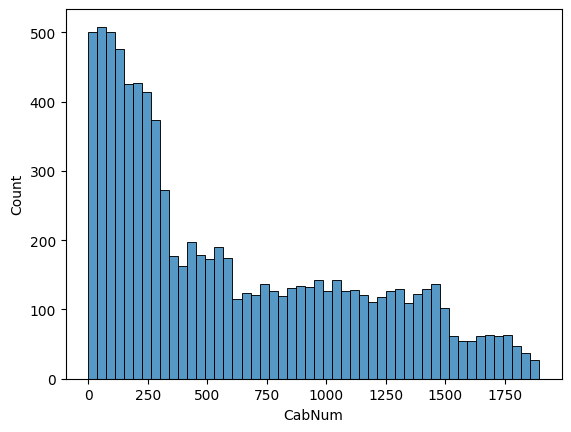

In [205]:
sns.histplot(x="CabNum", data=train, bins=50)

посмотрим, сколько человек было в группе с каждым пассажиром, сразу удалим ненужные столбцы:

In [206]:
train["GroupNum"] = train.PassengerId.str.extract("^(\d\d\d\d)")
train["PeopleNum"] = train.GroupNum.map(train.groupby("GroupNum").size())
train.drop(["CNB", "GroupNum"], axis=1, inplace=True)
test["GroupNum"] = test.PassengerId.str.extract("^(\d\d\d\d)")
test["PeopleNum"] = test.GroupNum.map(test.groupby("GroupNum").size())
test.drop(["CNB", "GroupNum"], axis=1, inplace=True)
with pd.option_context('display.max_columns', None):
    print(train.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  CabNum  Board  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  \
0        False       0 

зависимость выживания от числа пассажиров

<Axes: xlabel='PeopleNum', ylabel='Transported'>

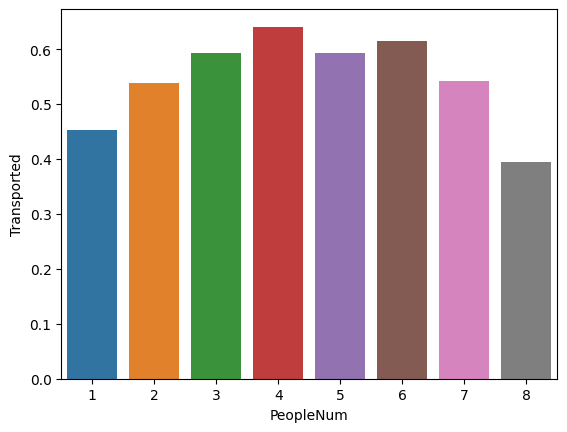

In [207]:
sns.barplot(x="PeopleNum", y="Transported", data=train, errorbar=None)

введем столбец IsAlone

44.73
55.27


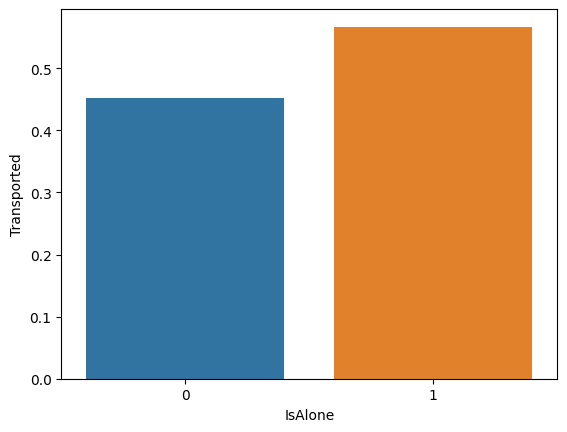

In [208]:
trt = [train, test]
for t in trt:
    t["IsAlone"] = 0
    t.loc[t["PeopleNum"] > 1, "IsAlone"] = 1
sns.barplot(x="IsAlone", y="Transported", data=train, errorbar=None)
print("%2.2f"%(train[train["IsAlone"] == 1].size/train.size*100))
print("%2.2f"%(train[train["IsAlone"] == 0].size/train.size*100))

заменим True False на 0 1

In [209]:
bool_mapping = {True: 1, False: 0}
for t in trt:
    t.VIP = t.VIP.map(bool_mapping)
    t.CryoSleep = t.CryoSleep.map(bool_mapping)
    t[["Deck_B", "Deck_C", "Deck_D", "Deck_E", "Deck_F", "Deck_G", "Deck_T"]] = t[["Deck_B", "Deck_C", "Deck_D", "Deck_E", "Deck_F", "Deck_G", "Deck_T"]].astype(int)
train.Transported = train.Transported.map(bool_mapping).astype(int)
with pd.option_context('display.max_columns', None):
    print(train.head())

  PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  \
0     0001_01     Europa        0.0  B/0/P  TRAPPIST-1e  39.0  0.0   
1     0002_01      Earth        0.0  F/0/S  TRAPPIST-1e  24.0  0.0   
2     0003_01     Europa        0.0  A/0/S  TRAPPIST-1e  58.0  1.0   
3     0003_02     Europa        0.0  A/0/S  TRAPPIST-1e  33.0  0.0   
4     0004_01      Earth        0.0  F/1/S  TRAPPIST-1e  16.0  0.0   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  CabNum  Board  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  \
0            0       0      0

распределение возрастов ~ стандартное, nan заменяем рандомными числами в пределах среднеквадратичного отклонения от среднего

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


179

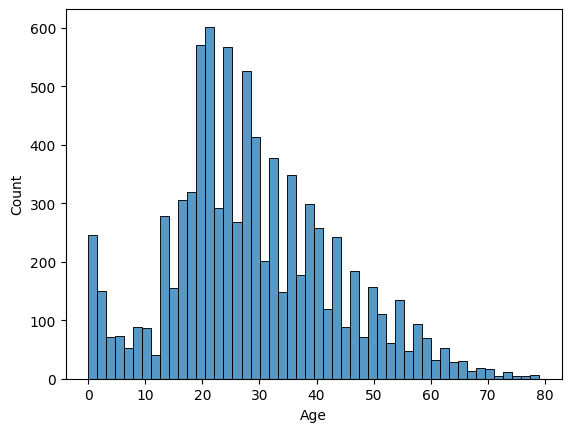

In [210]:
sns.histplot(x="Age", data=train, bins=50)
train.Age.isnull().sum()

In [211]:
for t in trt:
    m = t.Age.mean()
    s = t.Age.std()
    c = t.Age.isnull().sum()
    rv = np.random.randint(m-s, m+s, c)
    t.loc[t.Age.isnull(), "Age"] = rv
    t.Age = t.Age.astype(int)

заполним HomePlanet и Destination модами и применим OHE

201
182
  PassengerId  CryoSleep  Cabin  Age  VIP  RoomService  FoodCourt  \
0     0001_01        0.0  B/0/P   39  0.0          0.0        0.0   
1     0002_01        0.0  F/0/S   24  0.0        109.0        9.0   
2     0003_01        0.0  A/0/S   58  1.0         43.0     3576.0   
3     0003_02        0.0  A/0/S   33  0.0          0.0     1283.0   
4     0004_01        0.0  F/1/S   16  0.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck               Name  Transported  CabNum  \
0           0.0     0.0     0.0    Maham Ofracculy            0       0   
1          25.0   549.0    44.0       Juanna Vines            1       0   
2           0.0  6715.0    49.0      Altark Susent            0       0   
3         371.0  3329.0   193.0       Solam Susent            0       0   
4         151.0   565.0     2.0  Willy Santantines            1       1   

   Board  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  PeopleNum  \
0      0       1       0       0       0       

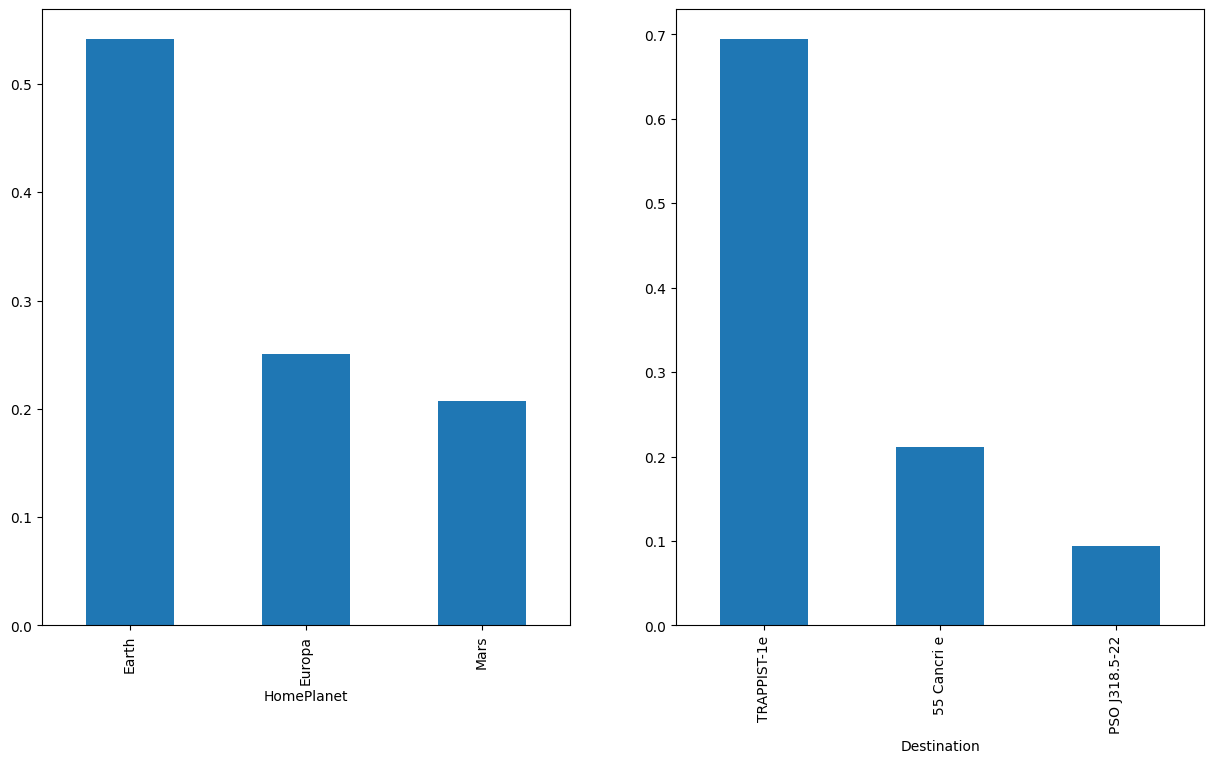

In [212]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
train.HomePlanet.value_counts(normalize=True).plot(kind="bar", ax=ax1)
train.Destination.value_counts(normalize=True).plot(kind="bar", ax=ax2)
print(train.HomePlanet.isnull().sum())
print(train.Destination.isnull().sum())
for t in trt:
    t.fillna({"HomePlanet": "Earth"}, inplace=True)
    t.fillna({"Destination": "TRAPPIST-1e"}, inplace=True)
train = pd.get_dummies(train, columns=["HomePlanet", "Destination"], drop_first=True)
test = pd.get_dummies(test, columns=["HomePlanet", "Destination"], drop_first=True)
trt = [train, test]
for t in trt:
    t[["HomePlanet_Europa", "HomePlanet_Mars", "Destination_PSO J318.5-22", "Destination_TRAPPIST-1e"]] = t[["HomePlanet_Europa", "HomePlanet_Mars", "Destination_PSO J318.5-22", "Destination_TRAPPIST-1e"]].astype(int)
with pd.option_context('display.max_columns', None):
    print(train.head())
    print(test.head())

визуализируем моды VIP и CryoSleep, затем заполним ими nan

217
203


,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_E,Deck_F,Deck_G,Deck_T,PeopleNum,IsAlone,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,B/0/P,39,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
1,0002_01,0,F/0/S,24,0,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,1,0,0,0,0,1
2,0003_01,0,A/0/S,58,1,43.0,3576.0,0.0,6715.0,49.0,...,0,0,0,0,2,1,1,0,0,1
3,0003_02,0,A/0/S,33,0,0.0,1283.0,371.0,3329.0,193.0,...,0,0,0,0,2,1,1,0,0,1
4,0004_01,0,F/1/S,16,0,303.0,70.0,151.0,565.0,2.0,...,0,1,0,0,1,0,0,0,0,1


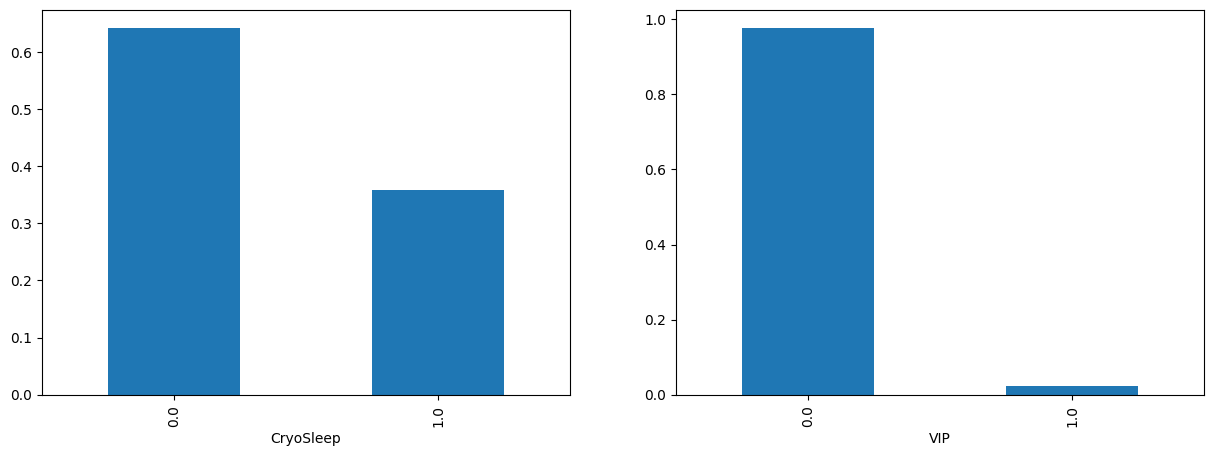

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train.CryoSleep.value_counts(normalize=True).plot(kind="bar", ax=axes[0])
train.VIP.value_counts(normalize=True).plot(kind="bar", ax=axes[1])
print(train.CryoSleep.isnull().sum())
print(train.VIP.isnull().sum())

for t in trt:
    t.fillna({"CryoSleep": 0, "VIP": 0}, inplace=True)
    t.CryoSleep = t.CryoSleep.astype(int)
    t.VIP = t.VIP.astype(int)
train.head()

построим гистограммы частот значений финансовых признаков

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

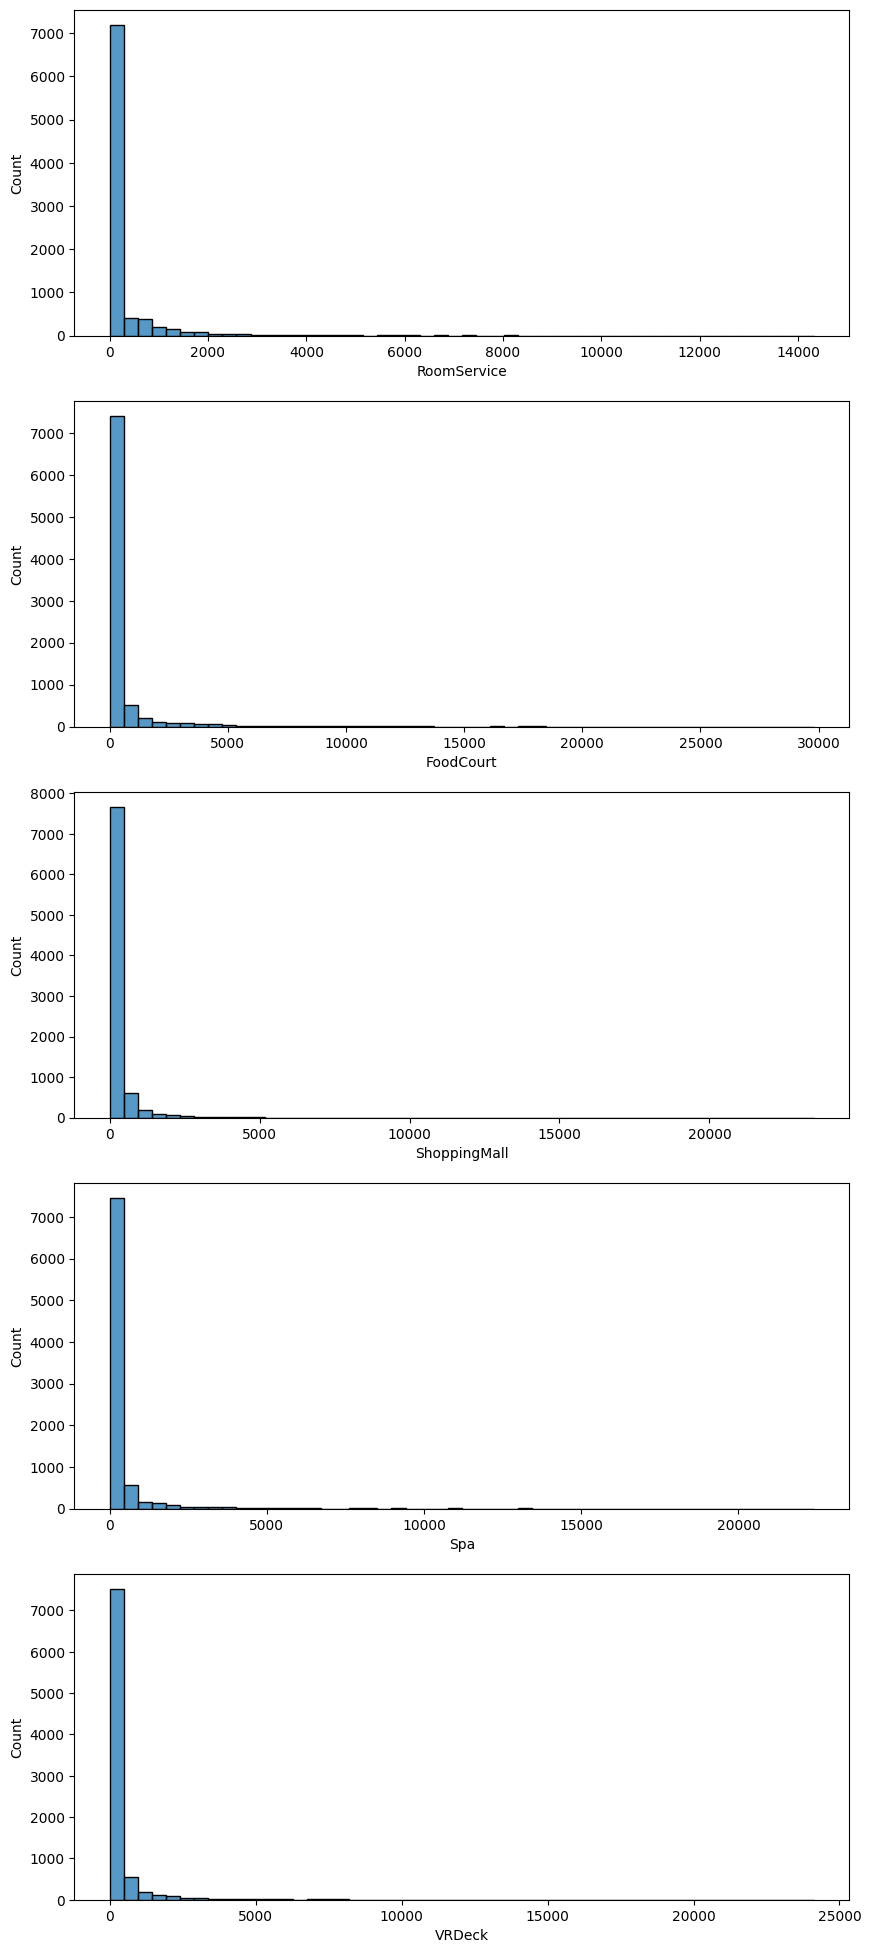

In [214]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)
for t in trt:
    t.fillna({"RoomService": 0, "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, "VRDeck": 0}, inplace=True)
sns.histplot(train['RoomService'], bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], bins=50, ax=ax[1]);
sns.histplot(train['ShoppingMall'], bins=50, ax=ax[2]);
sns.histplot(train['Spa'], bins=50, ax=ax[3]);
sns.histplot(train['VRDeck'], bins=50, ax=ax[4]);

для этих признаков выведем матрицу корреляции

<Axes: >

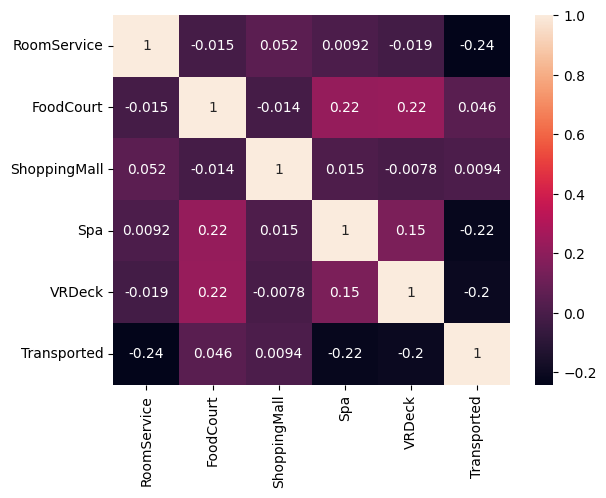

In [215]:
corr_matrix = train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]].corr()
sns.heatmap(corr_matrix, annot=True)

In [216]:
fin_features = ["FoodCourt", "ShoppingMall", "RoomService", "Spa", "VRDeck"]
for t in trt:
    t[fin_features] = t[fin_features].astype(float)
train.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_E,Deck_F,Deck_G,Deck_T,PeopleNum,IsAlone,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,B/0/P,39,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
1,0002_01,0,F/0/S,24,0,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,1,0,0,0,0,1
2,0003_01,0,A/0/S,58,1,43.0,3576.0,0.0,6715.0,49.0,...,0,0,0,0,2,1,1,0,0,1
3,0003_02,0,A/0/S,33,0,0.0,1283.0,371.0,3329.0,193.0,...,0,0,0,0,2,1,1,0,0,1
4,0004_01,0,F/1/S,16,0,303.0,70.0,151.0,565.0,2.0,...,0,1,0,0,1,0,0,0,0,1


удалим Cabin и Name

In [217]:
for t in trt:
    t.drop(["Cabin", "Name"], axis=1, inplace=True)
train.head()
with pd.option_context('display.max_columns', None):
    print(train.head())
    print(test.head())

  PassengerId  CryoSleep  Age  VIP  RoomService  FoodCourt  ShoppingMall  \
0     0001_01          0   39    0          0.0        0.0           0.0   
1     0002_01          0   24    0        109.0        9.0          25.0   
2     0003_01          0   58    1         43.0     3576.0           0.0   
3     0003_02          0   33    0          0.0     1283.0         371.0   
4     0004_01          0   16    0        303.0       70.0         151.0   

      Spa  VRDeck  Transported  CabNum  Board  Deck_B  Deck_C  Deck_D  Deck_E  \
0     0.0     0.0            0       0      0       1       0       0       0   
1   549.0    44.0            1       0      1       0       0       0       0   
2  6715.0    49.0            0       0      1       0       0       0       0   
3  3329.0   193.0            0       0      1       0       0       0       0   
4   565.0     2.0            1       1      1       0       0       0       0   

   Deck_F  Deck_G  Deck_T  PeopleNum  IsAlone  HomePlane

Построим матрицу корреляции для всех признаков

<Axes: >

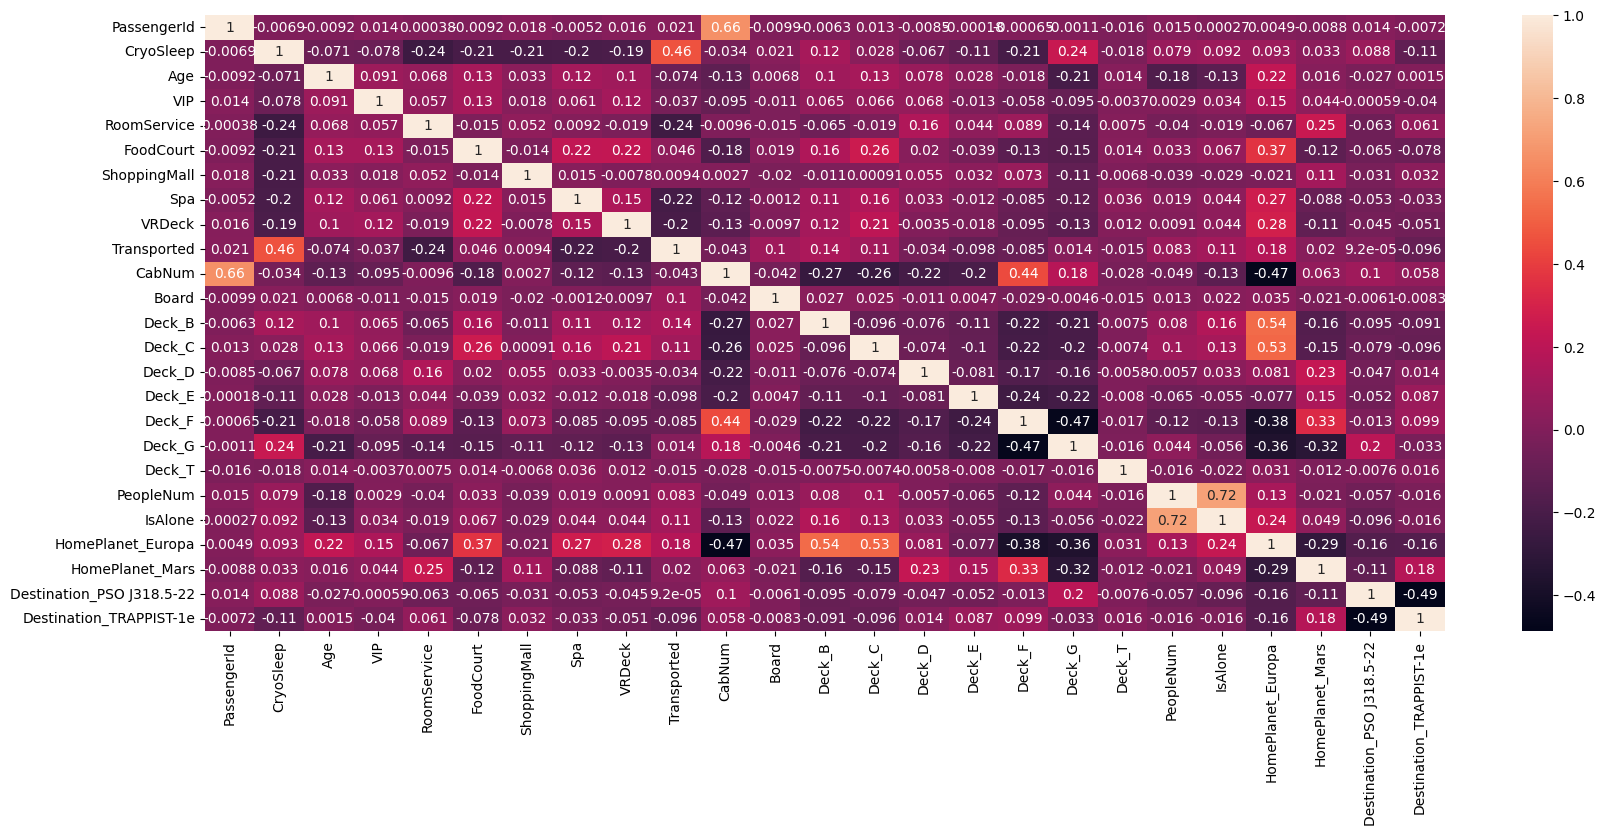

In [218]:
corr_matrix = train.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True)

Подготовим датасеты

In [220]:
x_train = train.drop(["PassengerId", "Transported"], axis=1)
y_train = train["Transported"]
x_test = test.drop("PassengerId", axis=1)

Обучим RandomForestClassifier выбрав для него лучшие гиперпараметры

In [221]:
clf = RandomForestClassifier(random_state=42)

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(x_train, y_train)

# Вывод результатов
print("Кросс-валидационные оценки для лучшей модели (валидация):", grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
print("Кросс-валидационные оценки для лучшей модели (тренировка):", grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучшая средняя точность на кросс-валидации:", grid_search.best_score_)

# Анализ переобучения
difference = grid_search.cv_results_['mean_train_score'][grid_search.best_index_] - grid_search.best_score_
print(f"Разница (train - validation): {difference:.3f}")
if difference > 0.1:
    print("Предупреждение: Возможное переобучение (разница > 0.1)")

Кросс-валидационные оценки для лучшей модели (валидация): 0.7997299048979538
Кросс-валидационные оценки для лучшей модели (тренировка): 0.8600535685764304

Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая средняя точность на кросс-валидации: 0.7997299048979538
Разница (train - validation): 0.060


Сохраним решение

In [222]:
best_rf = grid_search.best_estimator_
y_test = best_rf.predict(x_test)

In [223]:
res = pd.DataFrame({
    "PassengerId": test.PassengerId,
    "Transported": list(map(bool, y_test))
})
res.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [224]:
res.to_csv('submission.csv', index=False)

Результат: 0.80149